## Purpose

CIFAR10 is a dataset of images belonging to ten classes. We need to train a model to classify the images. Once the model is trained and makes predictions, we might be interested to find what features of an image made the model decide its classification. And to find that, the model seems to be a blackbox to inverstigate. However, with GradCAM it is no more the case. In retrospect, we can actually see which layer is focucing on which feature of a particular image so as to make the final prediction. As we move towards the penultimate convolution layer of the model, the dominating features come more clearly to our knowledge through GradCAM. 

The model might learn wrong and irrelevant features of an image for prediction and that would result in misclassification for certain images. In that case, CutOut augmentation technique becomes a powerful option that forces the model to learn the relevant features of the object in the image resulting in better accuracy. CutOut technique basically creates a patch of random size with respect to each image, with pixel value equal to the average of all the pixel values in the entire dataset.

To demonstrate, we will take a few examples and visulize the GradCAM result before and after CutOut.

## Pre-Processing

Import necessary libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Load the dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Visualize images from each class

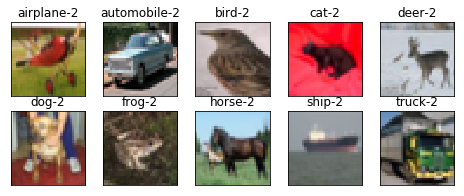

In [30]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    #img_num = np.random.randint(features_idx.shape[0])
    img_num = 2
    im = features_idx[img_num]
    class_names[i] = class_names[i] + '-' + str(img_num)
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Randomly select six images for GradCAM analysis pre and post CutOut image augmentation

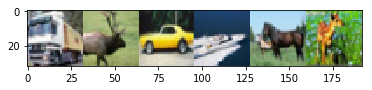

In [55]:
images = []
for i in [1, 34, 823, 870, 12, 1005]:
  im = train_features[i]
  images.append(im)

plt.imshow(np.hstack(images))

Taking the back of original data for visulalization purpose

In [0]:
train_features_bkp = train_features.copy()
train_labels_bkp = train_labels.copy()

Custom function to display learning history of the model

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Accuracy metric

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Normalizing the images

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Part A: GradCAM and Model running without CutOut

In [109]:
# Define the model
model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(32, 32, 3), name='Conv_1', border_mode='same'))    #32, 3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64, 3, 3, name='Conv_2', border_mode='same')) #32, 5
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, 3, 3, name='Conv_3', border_mode='same')) #32, 7
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_4', border_mode='same')) #32, 9
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_5', border_mode='same')) #32, 11
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_6', border_mode='same')) #32, 12
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_7', border_mode='same')) #32, 13
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2))) #16, 26


model.add(Conv2D(64, 1, 1, name='Conv_8_1x1', border_mode='same')) #16, 26
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, 3, 3, name='Conv_9', border_mode='same')) #16, 28
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_10', border_mode='same')) # 16, 30
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, 3, 3, name='Conv_11', border_mode='same')) # 16, 32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(10, 1, 1, name='Conv_12_1x1', border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(10, 16))

model.add(Flatten())

model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., name="Conv_1", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="Conv_2", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="Conv_3", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="Conv_4", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="Conv_5", padding="same")`
/usr/local/lib/python3.6/dist

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation_27 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 64)        256       
__________

In [62]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/EVA/ASGN9/epochs:{epoch:03d}-val_acc:{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=55)`
  if sys.path[0] == '':


Epoch 1/55
390/390 [==============================] - 160s 409ms/step - loss: 1.6412 - acc: 0.4264 - val_loss: 1.8607 - val_acc: 0.4841

Epoch 00001: val_acc improved from -inf to 0.48410, saving model to /content/gdrive/My Drive/EVA/ASGN9/epochs:001-val_acc:0.4841.hdf5
Epoch 2/55
390/390 [==============================] - 151s 388ms/step - loss: 1.1650 - acc: 0.5896 - val_loss: 1.3258 - val_acc: 0.5753

Epoch 00002: val_acc improved from 0.48410 to 0.57530, saving model to /content/gdrive/My Drive/EVA/ASGN9/epochs:002-val_acc:0.5753.hdf5
Epoch 3/55
390/390 [==============================] - 149s 381ms/step - loss: 0.9274 - acc: 0.6752 - val_loss: 1.0019 - val_acc: 0.6612

Epoch 00003: val_acc improved from 0.57530 to 0.66120, saving model to /content/gdrive/My Drive/EVA/ASGN9/epochs:003-val_acc:0.6612.hdf5
Epoch 4/55
390/390 [==============================] - 148s 380ms/step - loss: 0.8042 - acc: 0.7209 - val_loss: 0.8252 - val_acc: 0.7140

Epoch 00004: val_acc improved from 0.66120 t

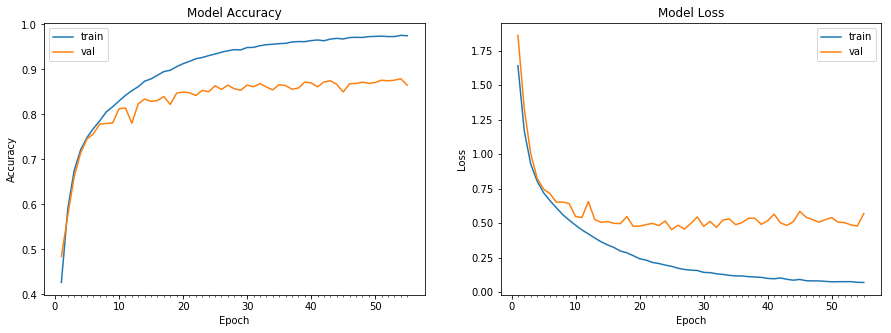

Accuracy on test data is: 86.48


In [71]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

callbacks_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 55, 
                                 validation_data = (test_features, test_labels), callbacks=callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
from keras.models import load_model
modelPath = r'/content/gdrive/My Drive/EVA/ASGN9/epochs:054-val_acc:0.8792.hdf5'
model = load_model(modelPath)

A custom function that takes index of an image in the dataset, name of the convolution layer for which GradCAM needs to be generated and the number of output channels from that particular convolution layer.

In [0]:
def get_grad_cam(img_idx, conv_layer, output_channel):
  x = train_features[img_idx]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(conv_layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(output_channel):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = train_features_bkp[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  images_stack = [img, superimposed_img]
  
  return images_stack


For each of the images of interest, displaying what features the model is looking at using GradCAM and Heatmap.

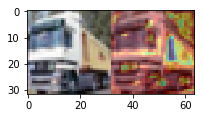

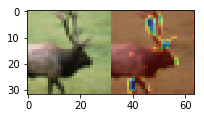

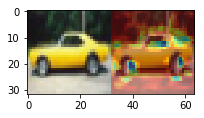

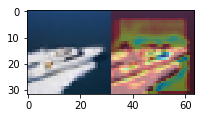

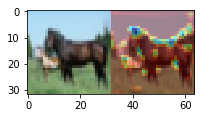

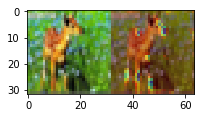

In [119]:
for i in [1, 34, 823, 870, 12, 1005]:
  images_stack = get_grad_cam(i, "Conv_6", 256)
  fig = plt.figure(figsize=(3,2))
  plt.imshow(np.hstack(images_stack))

The fourth one is an image of a ship. And from the heatmap, we can see that the model learns the background of the image along with the object. And, this might lead to misclassification as same background can be present of other images from different classes as well.

## Part B: GradCAM and Model running with CutOut

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1))

In [0]:
filepath="/content/gdrive/My Drive/EVA/ASGN9-2/epochs:{epoch:03d}-val_acc:{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=55)`
  


Epoch 1/55
390/390 [==============================] - 157s 404ms/step - loss: 1.7596 - acc: 0.3830 - val_loss: 1.9044 - val_acc: 0.4555

Epoch 00001: val_acc improved from -inf to 0.45550, saving model to /content/gdrive/My Drive/EVA/ASGN9-2/epochs:001-val_acc:0.4555.hdf5
Epoch 2/55
390/390 [==============================] - 150s 384ms/step - loss: 1.3204 - acc: 0.5266 - val_loss: 1.1987 - val_acc: 0.5907

Epoch 00002: val_acc improved from 0.45550 to 0.59070, saving model to /content/gdrive/My Drive/EVA/ASGN9-2/epochs:002-val_acc:0.5907.hdf5
Epoch 3/55
390/390 [==============================] - 149s 382ms/step - loss: 1.0731 - acc: 0.6183 - val_loss: 1.1337 - val_acc: 0.6179

Epoch 00003: val_acc improved from 0.59070 to 0.61790, saving model to /content/gdrive/My Drive/EVA/ASGN9-2/epochs:003-val_acc:0.6179.hdf5
Epoch 4/55
390/390 [==============================] - 149s 383ms/step - loss: 0.9158 - acc: 0.6773 - val_loss: 0.9337 - val_acc: 0.6832

Epoch 00004: val_acc improved from 0.6

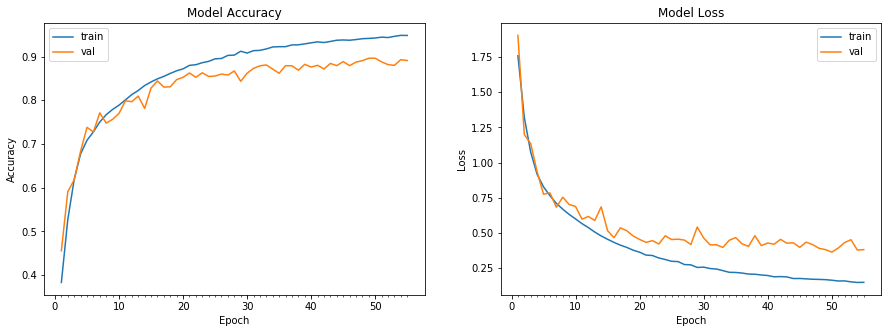

Accuracy on test data is: 89.10


In [110]:
callbacks_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 55, 
                                 validation_data = (test_features, test_labels), callbacks=callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

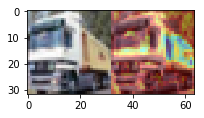

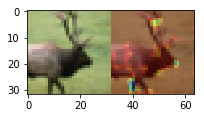

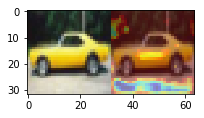

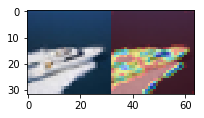

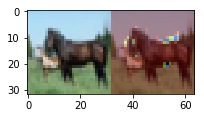

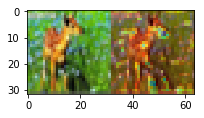

In [117]:
for i in [1, 34, 823, 870, 12, 1005]:
  images_stack = get_grad_cam(i, "Conv_6", 256)
  fig = plt.figure(figsize=(3,2))
  plt.imshow(np.hstack(images_stack))

## Conclusion

Definitely with application of CutOut image augmentation, the validation accuracy improved form 87% to 89%. Moreover, one interesting observation we can see with the image number four, that is an image of a ship. Before the usage of CutOut, the model was learning the background around the ship to classify it as evident from the GradCAM visualization. However, when CutOut was implimented, the model was forced to learn the features of the object only to make the prediction. Such changes in the learning pattern resulted in better accuracy.